<DIV ALIGN=CENTER>
# Tree Ensemble Models
## Xichen Huang and Elaine (Yinyin) Chen
February 10, 2017

This document covers how to implement three tree ensemble models, randomforest, gbm and XGBoost,  R to predict if blue color is present in a flag or not.
</DIV>  
---

In [1]:
# To use these models, you need to load the corresponding packages:
library(randomForest)  # random forest
library(gbm)  # gbm
library(xgboost)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1


In [2]:
# Let’s load the data.
flag = read.csv(file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data',
                header = FALSE)

In [3]:
head(flag[,10:28])

V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
5,1,1,0,1,1,1,0,green,0,0,0,0,1,0,0,1,0,0
3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,0,1,0
3,1,1,0,0,1,0,0,green,0,0,0,0,1,1,0,0,0,0
5,1,0,1,1,1,0,1,blue,0,0,0,0,0,0,1,1,1,0
3,1,0,1,1,0,0,0,gold,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,1,0,0


In [4]:
#str(flag)  # check what the data looks like, e.g. dimension, variables set. 
flag = flag[, c(2:17, 19:28)]  # take the numerical values
flag.y = as.numeric(flag$V13)  # Response Y: 0 if blue absent, 1 if blue present in the flag
head(flag)
flag.x = flag[, -12]  # Predictors X: the predictors should not contain v13
#head(flag.x)

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,⋯,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
5,1,648,16,10,2,0,3,5,1,⋯,0,0,0,0,1,0,0,1,0,0
3,1,29,3,6,6,0,0,3,1,⋯,0,0,0,0,1,0,0,0,1,0
4,1,2388,20,8,2,2,0,3,1,⋯,0,0,0,0,1,1,0,0,0,0
6,3,0,0,1,1,0,0,5,1,⋯,0,0,0,0,0,0,1,1,1,0
3,1,0,0,6,0,3,0,3,1,⋯,0,0,0,0,0,0,0,0,0,0
4,2,1247,7,10,5,0,2,3,1,⋯,0,0,0,0,1,0,0,1,0,0


In [5]:
#Then seperate data into trainning and test data set. We can record the row ID of the test data.
testidx = which((1:length(flag[,1])) %% 5 == 1)  # about 1/5 are test data.
length(testidx)

[1] 39

# Random Forest

In [6]:
# Random Forest
cat.names = paste('V', c(2, 3, 6, 7), sep = '')  # names of the categorical features
cat.names
flag.rf = flag
# convert the categorical features to factors. Originally, they are integers.
flag.rf[, cat.names] = lapply(flag[, cat.names], as.factor)
head(flag.rf[, cat.names])
rfModel = randomForest(as.factor(V13) ~ ., data = flag.rf[-testidx, ],
                       importance = T, ntree = 500)
yhat = predict(rfModel, flag.rf[testidx, ])
table(yhat, flag.rf[testidx, 'V13'])
mean(yhat != flag.rf[testidx, 'V13'])

[1] "V2" "V3" "V6" "V7"

V2,V3,V6,V7
5,1,10,2
3,1,6,6
4,1,8,2
6,3,1,1
3,1,6,0
4,2,10,5


    
yhat  0  1
   0 15 11
   1  4  9

[1] 0.3846154

# GBM method

[1] 18

Using 18 trees...


    
yhat  0  1
   0 17  4
   1  2 16

[1] 0.1538462

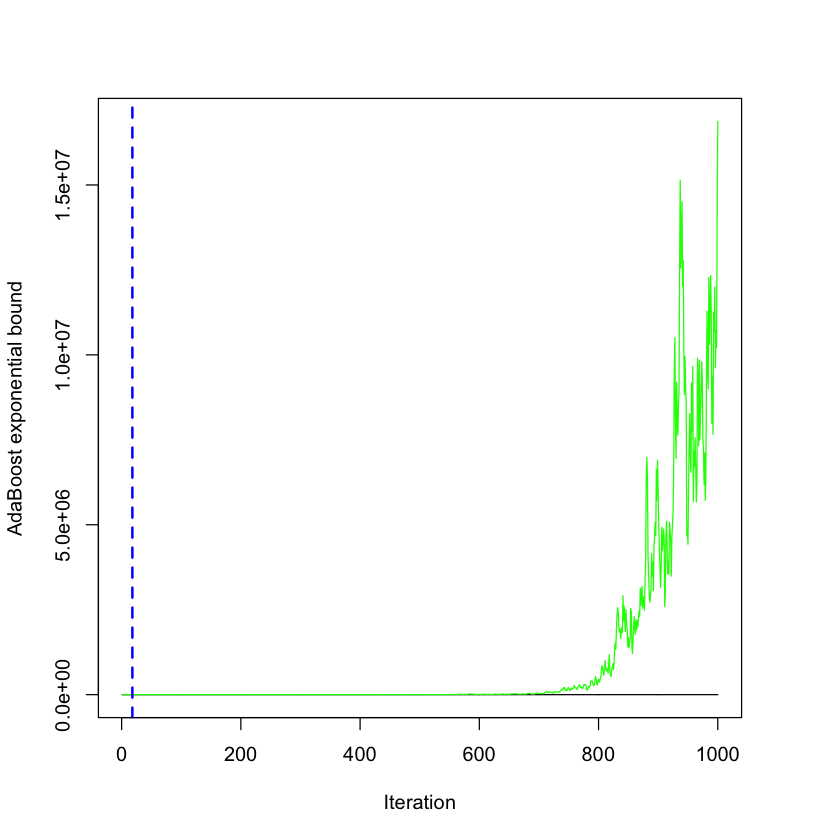

In [7]:
#GBM
gbm1 = gbm(V13 ~ ., data = flag.rf[-testidx, ], distribution = "adaboost",
           n.trees = 1000, shrinkage = 1, bag.fraction = 1, cv.folds = 5)
gbm.perf(gbm1, method = "cv")  # Estimates the optimal number of boosting iterations
yhat = predict(gbm1, flag.rf[testidx, ], type = 'response')  # returns probability
yhat = ifelse(yhat > 0.5, 1, 0)
table(yhat, flag.rf[testidx, 'V13'])
mean(yhat != flag.rf[testidx, 'V13'])

[1] 500

Using 500 trees...


    
yhat  0  1
   0 17  4
   1  2 16

[1] 0.1538462

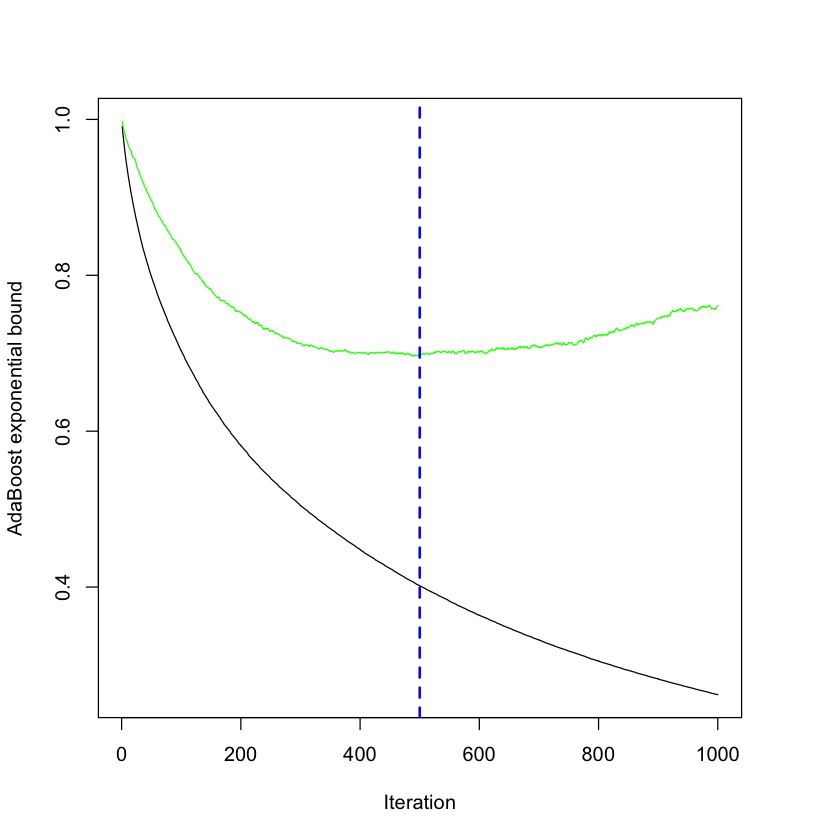

In [8]:

# Try different parameters: smaller shrinkage (lower learning rate)
gbm2 = gbm(V13 ~ ., data = flag.rf[-testidx, ], distribution = "adaboost",
           n.trees = 1000, shrinkage = 0.05, bag.fraction = 1, cv.folds = 5)
gbm.perf(gbm2, method = "cv")
yhat = predict(gbm2, flag.rf[testidx, ], type = 'response')  # probability
yhat = ifelse(yhat > 0.5, 1, 0)
table(yhat, flag.rf[testidx, 'V13'])
mean(yhat != flag.rf[testidx, 'V13'])

# XGBoost method

In [9]:
#XGBoost
#Now that we have four categorical predictors. XGBoost can only take numerical features. 
# If you feed a categorical feature to XGBoost, it will just code it as numerical with 1, 2, etc. 
# Let’s check this approach.

flag.x = apply(flag.x, 2, as.numeric)  # convert all predictors to numeric
# split to training and test sets
train.x = flag.x[-testidx,]
train.y = flag.y[-testidx]
test.x = flag.x[testidx,]
test.y = flag.y[testidx]

In [10]:
#We use 5-fold CV to select best number of iterations:

# ?xgb.cv  # open help file for the CV function.
set.seed(100)
cv.res = xgb.cv(data = train.x, label = train.y, 
                nfold = 5, nrounds = 15, max.depth = 2, eta = 1,
                objective = "binary:logistic")
# Set nrounds = 7

[1]	train-error:0.254715+0.024492	test-error:0.437850+0.072526 
[2]	train-error:0.175825+0.022619	test-error:0.366223+0.079062 
[3]	train-error:0.100068+0.022302	test-error:0.276290+0.095458 
[4]	train-error:0.096855+0.017440	test-error:0.230914+0.157125 
[5]	train-error:0.072648+0.026295	test-error:0.218414+0.086943 
[6]	train-error:0.053188+0.025777	test-error:0.218199+0.100117 
[7]	train-error:0.045110+0.018050	test-error:0.198844+0.097788 
[8]	train-error:0.035459+0.010909	test-error:0.212164+0.080866 
[9]	train-error:0.025794+0.006004	test-error:0.199046+0.087432 
[10]	train-error:0.022542+0.011794	test-error:0.211747+0.108428 
[11]	train-error:0.022555+0.010676	test-error:0.205497+0.103216 
[12]	train-error:0.016116+0.008822	test-error:0.205497+0.085578 
[13]	train-error:0.009678+0.007902	test-error:0.205712+0.090524 
[14]	train-error:0.011291+0.006452	test-error:0.179691+0.080262 
[15]	train-error:0.008065+0.005101	test-error:0.186142+0.098493 


In [11]:
#Then fit the model. You can set parameters for “xgboost” function, and the help file is 
# here: http://xgboost.readthedocs.io/en/latest/parameter.html

bst = xgboost(data = train.x, label = train.y, max.depth = 2, eta = 1, 
              nround = 7 , objective = "binary:logistic")
yhat = predict(bst, test.x)  # predictions are probabilities.
yhat = as.numeric(yhat > 0.5)  # hard thresholding: 0 or 1
mean(yhat != test.y)


[1]	train-error:0.277419 
[2]	train-error:0.219355 
[3]	train-error:0.180645 
[4]	train-error:0.141935 
[5]	train-error:0.070968 
[6]	train-error:0.083871 
[7]	train-error:0.070968 


[1] 0.1794872

In [12]:
str(flag)
class(flag)

'data.frame':	194 obs. of  26 variables:
 $ V2 : int  5 3 4 6 3 4 1 1 2 2 ...
 $ V3 : int  1 1 1 3 1 2 4 4 3 3 ...
 $ V4 : int  648 29 2388 0 0 1247 0 0 2777 2777 ...
 $ V5 : int  16 3 20 0 0 7 0 0 28 28 ...
 $ V6 : int  10 6 8 1 6 10 1 1 2 2 ...
 $ V7 : int  2 6 2 1 0 5 1 1 0 0 ...
 $ V8 : int  0 0 2 0 3 0 0 0 0 0 ...
 $ V9 : int  3 0 0 0 0 2 1 1 3 3 ...
 $ V10: int  5 3 3 5 3 3 3 5 2 3 ...
 $ V11: int  1 1 1 1 1 1 0 1 0 0 ...
 $ V12: int  1 0 1 0 0 0 0 0 0 0 ...
 $ V13: int  0 0 0 1 1 0 1 1 1 1 ...
 $ V14: int  1 1 0 1 1 1 0 1 0 1 ...
 $ V15: int  1 0 1 1 0 0 1 1 1 1 ...
 $ V16: int  1 1 0 0 0 1 0 1 0 0 ...
 $ V17: int  0 0 0 1 0 0 1 0 0 0 ...
 $ V19: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V20: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V21: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V22: int  0 0 0 0 0 0 0 0 0 0 ...
 $ V23: int  1 1 1 0 0 1 0 1 0 1 ...
 $ V24: int  0 0 1 0 0 0 0 0 0 0 ...
 $ V25: int  0 0 0 1 0 0 0 1 0 0 ...
 $ V26: int  1 0 0 1 0 1 0 0 0 0 ...
 $ V27: int  0 1 0 1 0 0 1 0 0 0 ...
 $ V28: int  

[1] "data.frame"

In [13]:
# The above model treats the categorical features as continuous. A better approach might be to 
# create dummy variables for the categorical variables, which enlarges pp and increases the computing time. 
# Les’s check what the prediction accuracy is by taking this approach.
cat.names = paste('V', c(2, 3, 6, 7), sep = '')  # names of the categorical features, used to subset X
flag.dum.x = data.frame(flag)  # convert to data frame before lapply the as.factor function
flag.dum.x[, cat.names] = lapply(flag.dum.x[, cat.names], as.factor)
head(flag.dum.x[, cat.names])
# ?model.matrix
# model.matrix creates a design (or model) matrix, e.g., by expanding factors to a set of dummary variables 
# (depending on the contrasts) and expanding interactions similarly.
dum.x = model.matrix(V13 ~. -1, data = flag.dum.x)   # Here -1 means no intercept, while no -1 means with intercept
head(dum.x)
names(dum.x)
train.dum.x = dum.x[-testidx, ]
test.dum.x = dum.x[testidx, ]

# train the model
set.seed(100)
cv.dum = xgb.cv(data =train.dum.x, label = train.y, nfold = 5, nrounds = 10,
                max.depth = 2, eta = 1, objective = "binary:logistic")
# set nround = 7
bst.dum = xgboost(data = train.dum.x, label = train.y, max.depth = 2, 
                  eta = 1, nround = 7, objective = "binary:logistic")
yhat = predict(bst.dum, test.dum.x)  # predictions are probabilities.
yhat = as.numeric(yhat > 0.5)  # hard thresholding: 0 or 1
mean(yhat != test.y)

V2,V3,V6,V7
5,1,10,2
3,1,6,6
4,1,8,2
6,3,1,1
3,1,6,0
4,2,10,5


,V21,V22,V23,V24,V25,V26,V32,V33,V34,V4,⋯,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
1,0,0,0,0,1,0,0,0,0,648,⋯,0,0,0,0,1,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,29,⋯,0,0,0,0,1,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,2388,⋯,0,0,0,0,1,1,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,⋯,0,0,0,0,0,0,1,1,1,0
5,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,1,0,0,1247,⋯,0,0,0,0,1,0,0,1,0,0


NULL

[1]	train-error:0.240303+0.016087	test-error:0.290000+0.069788 
[2]	train-error:0.220909+0.039940	test-error:0.322903+0.074336 
[3]	train-error:0.159552+0.040369	test-error:0.289812+0.051193 
[4]	train-error:0.106480+0.009749	test-error:0.206949+0.049964 
[5]	train-error:0.082312+0.014236	test-error:0.174261+0.043861 
[6]	train-error:0.080609+0.013199	test-error:0.186747+0.058239 
[7]	train-error:0.054815+0.016335	test-error:0.167191+0.078695 
[8]	train-error:0.049988+0.010636	test-error:0.179677+0.086012 
[9]	train-error:0.038685+0.010561	test-error:0.192581+0.106469 
[10]	train-error:0.032246+0.005001	test-error:0.167191+0.093222 
[1]	train-error:0.245161 
[2]	train-error:0.174194 
[3]	train-error:0.148387 
[4]	train-error:0.129032 
[5]	train-error:0.083871 
[6]	train-error:0.070968 
[7]	train-error:0.064516 


[1] 0.1538462

In [14]:
names(dum.x)
dim(dum.x)
dim(flag.dum.x)
head(dum.x[,1:10])
head(dum.x[,11:20])
head(dum.x[,21:30])
head(dum.x[,31:40])
head(dum.x[,41:46])

NULL

[1] 194  46

[1] 194  26

,V21,V22,V23,V24,V25,V26,V32,V33,V34,V4
1,0,0,0,0,1,0,0,0,0,648
2,0,0,1,0,0,0,0,0,0,29
3,0,0,0,1,0,0,0,0,0,2388
4,0,0,0,0,0,1,0,1,0,0
5,0,0,1,0,0,0,0,0,0,0
6,0,0,0,1,0,0,1,0,0,1247


,V5,V62,V63,V64,V65,V66,V67,V68,V69,V610
1,16,0,0,0,0,0,0,0,0,1
2,3,0,0,0,0,1,0,0,0,0
3,20,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,7,0,0,0,0,0,0,0,0,1


,V71,V72,V73,V74,V75,V76,V77,V8,V9,V10
1,0,1,0,0,0,0,0,0,3,5
2,0,0,0,0,0,1,0,0,0,3
3,0,1,0,0,0,0,0,2,0,3
4,1,0,0,0,0,0,0,0,0,5
5,0,0,0,0,0,0,0,3,0,3
6,0,0,0,0,1,0,0,0,2,3


,V11,V12,V14,V15,V16,V17,V19,V20,V21,V22
1,1,1,1,1,1,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0
4,1,0,1,1,0,1,0,0,0,0
5,1,0,1,0,0,0,0,0,0,0
6,1,0,1,0,1,0,0,0,0,0


,V23,V24,V25,V26,V27,V28
1,1,0,0,1,0,0
2,1,0,0,0,1,0
3,1,1,0,0,0,0
4,0,0,1,1,1,0
5,0,0,0,0,0,0
6,1,0,0,1,0,0


The above models are built for classification. As you can see, we specify objective = ‘binary:logistic’, meaning we do binary classification and the error metric on the validation data is the binary classification error rate. For the regression problem, you can specify objective = ‘reg:linear’. Then the error metric is the root mean square error (rmse).

